# LLM - Visual captioning

## Imagen imagetext
- https://cloud.google.com/vertex-ai/docs/generative-ai/image/image-captioning

In [2]:

import vertexai
from google.cloud import bigquery
from tools import *
from bq import save_bq


PROJECT_ID = "ml-demo-384110"  # @param {type:"string"}
vertexai.init(project=PROJECT_ID, location="us-central1")
client = bigquery.Client(project=PROJECT_ID)
bucket = "ml-demo-384110-bucket"

%load_ext google.cloud.bigquery

In [2]:
%%bigquery df
      SELECT distinct uri, Id,
      FROM `immo_us_enriched.image_cloudvision_labels_1k` 
      where uri not in (
            SELECT uri FROM `ml-demo-384110.immo_us.visual_captioning` 
            where caption_fr != "" and caption_en != "" 
            )
            #limit 100



Query is running:   0%|          |

Downloading:   0%|          |

In [3]:
df.describe()


,uri,Id
count,425,425
unique,425,41
top,gs://ml-demo-384110-bucket/dataset/immo/images...,safti-1-807163
freq,1,20


## Process description


## Translate result to analyse quality in different language.

In [4]:
%%bigquery



create or replace table   ml-demo-384110.immo_us_enriched.visual_captioning_translated as (
  SELECT uri,
  text_content as caption_fr,  
  string(ml_translate_result.translations[0].translated_text) as caption_fr_translated_en, 
  caption_en,  
  string(ml_translate_result.translations[0].detected_language_code) as detected_language_code,
  ml_translate_status

  from ML.TRANSLATE(
  model `ml-demo-384110.immo_us_enriched.bqml-cloud-ai-translate`,
  (SELECT caption_fr AS text_content, caption_en, uri from `ml-demo-384110.immo_us.visual_captioning` where caption_fr != "" ),
  STRUCT('translate_text' AS translate_mode, 'en' AS target_language_code)
)
);

Query is running:   0%|          |

""


## Load results

In [2]:
%%bigquery df

select * from    ml-demo-384110.immo_us_enriched.visual_captioning_translated ;



Query is running:   0%|          |

Downloading:   0%|          |

In [7]:
df


,caption_fr,caption_fr_translated_en,caption_en,detected_language_code,ml_translate_status
0,un plan d' étage de la maison principale,a floor plan of the main house,a floor plan of a house with the word maison o...,fr,
1,une grande maison avec un arbre à l' extérieur,a big house with a tree outside,a house with a basketball hoop in front of it,fr,
2,une photo d' une salle de bain par hosman,a picture of a bathroom by hosman,a bathroom with a sink and a mirror and the wo...,fr,
3,une chambre avec des murs rouges et un lit,a bedroom with red walls and a bed,a bedroom with red walls and a bed with a blue...,fr,
4,un plan du 1er étage d' une maison,a plan of the 1st floor of a house,a floor plan of a house with the word escalier...,fr,
...,...,...,...,...,...
1239,une chambre avec un lit et une étagère avec de...,a bedroom with a bed and a shelf with games,a bedroom with a bed and a shelf full of books...,fr,
1240,une chambre avec un lit et une étagère avec de...,a bedroom with a bed and a shelf with games,a bedroom with a bed and a shelf full of books...,fr,
1241,une chambre avec un lit et une étagère avec de...,a bedroom with a bed and a shelf with games,a bedroom with a bed and a shelf full of books...,fr,
1242,une chambre avec un lit et une étagère avec de...,a bedroom with a bed and a shelf with games,a bedroom with a bed and a shelf full of books...,fr,


## Test python package Rouge

In [8]:
%pip install rouge

Note: you may need to restart the kernel to use updated packages.


In [8]:
from rouge import Rouge 
rouge = Rouge()

def calculate_rouge(candidate : str, reference : str, score_type : str
                    # rouge-1 , rouge-2, to rouge-5, rouge-l
                    ):
    '''
    candidate, reference: generated and ground-truth sentences
    '''
    scores = rouge.get_scores(candidate, reference)

    return scores[0][score_type]

calculate_rouge("a living room with a red sofa and an umbrella hanging from the ceiling", 
                "a living room with a red couch and stairs leading to the kitchen", 'rouge-1') #['r'] 

{'r': 0.5833333333333334, 'p': 0.5384615384615384, 'f': 0.559999995008}

In [18]:

df[f'caption_rouge1_p' ] = df.apply(
    lambda x: calculate_rouge(x['caption_fr_translated_en'] , x['caption_en'],'rouge-1')["p"], axis=1)

df[f'caption_rouge1_r' ] = df.apply(
    lambda x: calculate_rouge(x['caption_fr_translated_en'] , x['caption_en'],'rouge-1')["r"], axis=1)

df[f'caption_rouge1_f' ] = df.apply(
    lambda x: calculate_rouge(x['caption_fr_translated_en'] , x['caption_en'],'rouge-1')["f"], axis=1)



df

,caption_fr,caption_fr_translated_en,caption_en,detected_language_code,ml_translate_status,caption_rouge1_p,caption_rouge1_r,caption_rouge1_f
0,un plan d' étage de la maison principale,a floor plan of the main house,a floor plan of a house with the word maison o...,fr,,0.857143,0.545455,0.666667
1,une grande maison avec un arbre à l' extérieur,a big house with a tree outside,a house with a basketball hoop in front of it,fr,,0.500000,0.333333,0.400000
2,une photo d' une salle de bain par hosman,a picture of a bathroom by hosman,a bathroom with a sink and a mirror and the wo...,fr,,0.500000,0.272727,0.352941
3,une chambre avec des murs rouges et un lit,a bedroom with red walls and a bed,a bedroom with red walls and a bed with a blue...,fr,,1.000000,0.777778,0.875000
4,un plan du 1er étage d' une maison,a plan of the 1st floor of a house,a floor plan of a house with the word escalier...,fr,,0.857143,0.545455,0.666667
...,...,...,...,...,...,...,...,...
1239,une chambre avec un lit et une étagère avec de...,a bedroom with a bed and a shelf with games,a bedroom with a bed and a shelf full of books...,fr,,0.857143,0.333333,0.480000
1240,une chambre avec un lit et une étagère avec de...,a bedroom with a bed and a shelf with games,a bedroom with a bed and a shelf full of books...,fr,,0.857143,0.333333,0.480000
1241,une chambre avec un lit et une étagère avec de...,a bedroom with a bed and a shelf with games,a bedroom with a bed and a shelf full of books...,fr,,0.857143,0.333333,0.480000
1242,une chambre avec un lit et une étagère avec de...,a bedroom with a bed and a shelf with games,a bedroom with a bed and a shelf full of books...,fr,,0.857143,0.333333,0.480000


In [20]:
score_type = 'rouge-l'
df[f'caption_rougel_p' ] = df.apply(
    lambda x: calculate_rouge(x['caption_fr_translated_en'] , x['caption_en'],score_type)["p"], axis=1)

df[f'caption_rougel_r' ] = df.apply(
    lambda x: calculate_rouge(x['caption_fr_translated_en'] , x['caption_en'],score_type)["r"], axis=1)

df[f'caption_rougel_f' ] = df.apply(
    lambda x: calculate_rouge(x['caption_fr_translated_en'] , x['caption_en'],score_type)["f"], axis=1)



df

,caption_fr,caption_fr_translated_en,caption_en,detected_language_code,ml_translate_status,caption_rouge1_p,caption_rouge1_r,caption_rouge1_f,caption_rougel_p,caption_rougel_r,caption_rougel_f
0,un plan d' étage de la maison principale,a floor plan of the main house,a floor plan of a house with the word maison o...,fr,,0.857143,0.545455,0.666667,0.714286,0.454545,0.555556
1,une grande maison avec un arbre à l' extérieur,a big house with a tree outside,a house with a basketball hoop in front of it,fr,,0.500000,0.333333,0.400000,0.500000,0.333333,0.400000
2,une photo d' une salle de bain par hosman,a picture of a bathroom by hosman,a bathroom with a sink and a mirror and the wo...,fr,,0.500000,0.272727,0.352941,0.333333,0.181818,0.235294
3,une chambre avec des murs rouges et un lit,a bedroom with red walls and a bed,a bedroom with red walls and a bed with a blue...,fr,,1.000000,0.777778,0.875000,1.000000,0.777778,0.875000
4,un plan du 1er étage d' une maison,a plan of the 1st floor of a house,a floor plan of a house with the word escalier...,fr,,0.857143,0.545455,0.666667,0.571429,0.363636,0.444444
...,...,...,...,...,...,...,...,...,...,...,...
1239,une chambre avec un lit et une étagère avec de...,a bedroom with a bed and a shelf with games,a bedroom with a bed and a shelf full of books...,fr,,0.857143,0.333333,0.480000,0.857143,0.333333,0.480000
1240,une chambre avec un lit et une étagère avec de...,a bedroom with a bed and a shelf with games,a bedroom with a bed and a shelf full of books...,fr,,0.857143,0.333333,0.480000,0.857143,0.333333,0.480000
1241,une chambre avec un lit et une étagère avec de...,a bedroom with a bed and a shelf with games,a bedroom with a bed and a shelf full of books...,fr,,0.857143,0.333333,0.480000,0.857143,0.333333,0.480000
1242,une chambre avec un lit et une étagère avec de...,a bedroom with a bed and a shelf with games,a bedroom with a bed and a shelf full of books...,fr,,0.857143,0.333333,0.480000,0.857143,0.333333,0.480000


In [21]:
df.describe()

,caption_rouge1_p,caption_rouge1_r,caption_rouge1_f,caption_rougel_p,caption_rougel_r,caption_rougel_f
count,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000
mean,0.620158,0.550067,0.575481,0.579039,0.513983,0.537453
std,0.195800,0.181355,0.177201,0.211059,0.196611,0.193693
min,0.125000,0.111111,0.117647,0.100000,0.090909,0.095238
25%,0.500000,0.416667,0.461538,0.428571,0.363636,0.400000
50%,0.625000,0.555556,0.571429,0.571429,0.500000,0.555556
75%,0.750000,0.666667,0.695652,0.714286,0.636364,0.666667
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [26]:
df.head()

,caption_fr,caption_fr_translated_en,caption_en,detected_language_code,ml_translate_status,caption_rouge1_p,caption_rouge1_r,caption_rouge1_f,caption_rougel_p,caption_rougel_r,caption_rougel_f
0,un plan d' étage de la maison principale,a floor plan of the main house,a floor plan of a house with the word maison o...,fr,,0.857143,0.545455,0.666667,0.714286,0.454545,0.555556
1,une grande maison avec un arbre à l' extérieur,a big house with a tree outside,a house with a basketball hoop in front of it,fr,,0.500000,0.333333,0.400000,0.500000,0.333333,0.400000
2,une photo d' une salle de bain par hosman,a picture of a bathroom by hosman,a bathroom with a sink and a mirror and the wo...,fr,,0.500000,0.272727,0.352941,0.333333,0.181818,0.235294
3,une chambre avec des murs rouges et un lit,a bedroom with red walls and a bed,a bedroom with red walls and a bed with a blue...,fr,,1.000000,0.777778,0.875000,1.000000,0.777778,0.875000
4,un plan du 1er étage d' une maison,a plan of the 1st floor of a house,a floor plan of a house with the word escalier...,fr,,0.857143,0.545455,0.666667,0.571429,0.363636,0.444444


<Axes: >

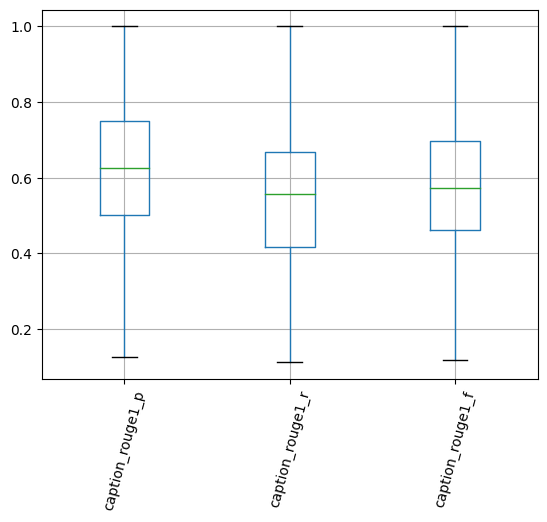

In [33]:
df.boxplot(column=["caption_rouge1_p", "caption_rouge1_r", "caption_rouge1_f",
#           "caption_rougel_p", "caption_rougel_r",	"caption_rougel_f"
           ],  rot=75, fontsize=10) 


<Axes: >

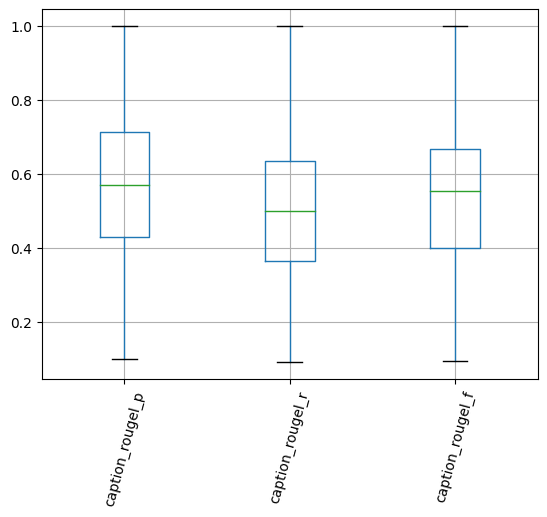

In [34]:

df.boxplot(column=[#"caption_rouge1_p", "caption_rouge1_r", "caption_rouge1_f",
           "caption_rougel_p", "caption_rougel_r",	"caption_rougel_f"],  rot=75, fontsize=10) 

In [45]:
caption_rouge1 = df.loc[:, df.columns.isin(
    [#"caption_rouge1_p", "caption_rouge1_r", "caption_rouge1_f",
           "caption_rougel_p", "caption_rougel_r",	"caption_rougel_f"]
)]
caption_rouge1.describe() 

,caption_rougel_p,caption_rougel_r,caption_rougel_f
count,1244.000000,1244.000000,1244.000000
mean,0.579039,0.513983,0.537453
std,0.211059,0.196611,0.193693
min,0.100000,0.090909,0.095238
25%,0.428571,0.363636,0.400000
50%,0.571429,0.500000,0.555556
75%,0.714286,0.636364,0.666667
max,1.000000,1.000000,1.000000


In [10]:
caption_rouge1.boxplot( rot=75, fontsize=10) 

NameError: name 'caption_rouge1' is not defined

In [37]:
df[]

,caption_fr,caption_fr_translated_en,caption_en,detected_language_code,ml_translate_status,caption_rouge1_p,caption_rouge1_r,caption_rouge1_f,caption_rougel_p,caption_rougel_r,caption_rougel_f
0,un plan d' étage de la maison principale,a floor plan of the main house,a floor plan of a house with the word maison o...,fr,,0.857143,0.545455,0.666667,0.714286,0.454545,0.555556
1,une grande maison avec un arbre à l' extérieur,a big house with a tree outside,a house with a basketball hoop in front of it,fr,,0.500000,0.333333,0.400000,0.500000,0.333333,0.400000
2,une photo d' une salle de bain par hosman,a picture of a bathroom by hosman,a bathroom with a sink and a mirror and the wo...,fr,,0.500000,0.272727,0.352941,0.333333,0.181818,0.235294
3,une chambre avec des murs rouges et un lit,a bedroom with red walls and a bed,a bedroom with red walls and a bed with a blue...,fr,,1.000000,0.777778,0.875000,1.000000,0.777778,0.875000
4,un plan du 1er étage d' une maison,a plan of the 1st floor of a house,a floor plan of a house with the word escalier...,fr,,0.857143,0.545455,0.666667,0.571429,0.363636,0.444444
...,...,...,...,...,...,...,...,...,...,...,...
1239,une chambre avec un lit et une étagère avec de...,a bedroom with a bed and a shelf with games,a bedroom with a bed and a shelf full of books...,fr,,0.857143,0.333333,0.480000,0.857143,0.333333,0.480000
1240,une chambre avec un lit et une étagère avec de...,a bedroom with a bed and a shelf with games,a bedroom with a bed and a shelf full of books...,fr,,0.857143,0.333333,0.480000,0.857143,0.333333,0.480000
1241,une chambre avec un lit et une étagère avec de...,a bedroom with a bed and a shelf with games,a bedroom with a bed and a shelf full of books...,fr,,0.857143,0.333333,0.480000,0.857143,0.333333,0.480000
1242,une chambre avec un lit et une étagère avec de...,a bedroom with a bed and a shelf with games,a bedroom with a bed and a shelf full of books...,fr,,0.857143,0.333333,0.480000,0.857143,0.333333,0.480000


## Test rouge-score package
%pip install rouge-score


In [3]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
scores = scorer.score('The quick brown fox jumps over the lazy dog',
                      'The quick brown dog jumps on the log.')


scores                      

{'rouge1': Score(precision=0.75, recall=0.6666666666666666, fmeasure=0.7058823529411765),
 'rougeL': Score(precision=0.625, recall=0.5555555555555556, fmeasure=0.5882352941176471)}

In [47]:
%pip install rouge-score

Note: you may need to restart the kernel to use updated packages.


## Test rouge_scorer python package

In [26]:


from rouge_score import rouge_scorer

rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=False)

def calculate_rouge_score(candidate : str, reference : str, score_type : str
                    # rouge-1 , rouge-2, to rouge-5, rouge-l
                    ):

    '''
    candidate, reference: generated and ground-truth sentences
    '''
#    scores = rouge.get_scores(candidate, reference)
    scores = rouge_scorer.score(candidate, reference)
    #return scores
    return scores[score_type]



calculate_rouge_score("a living room with a red sofa and an umbrella hanging from the ceiling", 
                "a living room with a red couch and stairs leading to the kitchen", 'rougeL')

Score(precision=0.6153846153846154, recall=0.5714285714285714, fmeasure=0.5925925925925927)

In [24]:
calculate_rouge_evaluate("a living room with a red sofa and an umbrella hanging from the ceiling", 
                "a living room with a red couch and stairs leading to the kitchen", 'rougeL')

0.5925925925925927

In [61]:
score_type = 'rougeL'
df[f'caption_rouge_score_l_p' ] = df.apply(
    lambda x: calculate_rouge_score(x['caption_fr_translated_en'] , x['caption_en'],score_type).precision, axis=1)

df[f'caption_rouge_scorel_r' ] = df.apply(
    lambda x: calculate_rouge_score(x['caption_fr_translated_en'] , x['caption_en'],score_type).recall, axis=1)

df[f'caption_rouge_scorel_f' ] = df.apply(
    lambda x: calculate_rouge_score(x['caption_fr_translated_en'] , x['caption_en'],score_type).fmeasure, axis=1)


score_type = 'rouge1'
df[f'caption_rouge_score_1_p' ] = df.apply(
    lambda x: calculate_rouge_score(x['caption_fr_translated_en'] , x['caption_en'],score_type).precision, axis=1)

df[f'caption_rouge_score_1_r' ] = df.apply(
    lambda x: calculate_rouge_score(x['caption_fr_translated_en'] , x['caption_en'],score_type).recall, axis=1)

df[f'caption_rouge_score_1_f' ] = df.apply(
    lambda x: calculate_rouge_score(x['caption_fr_translated_en'] , x['caption_en'],score_type).fmeasure, axis=1)


df

,caption_fr,caption_fr_translated_en,caption_en,detected_language_code,ml_translate_status,caption_rouge1_p,caption_rouge1_r,caption_rouge1_f,caption_rougel_p,caption_rougel_r,caption_rougel_f,caption_rouge_score_l_p,caption_rouge_scorel_r,caption_rouge_scorel_f,caption_rouge_score_1_p,caption_rouge_score_1_r,caption_rouge_score_1_f
0,un plan d' étage de la maison principale,a floor plan of the main house,a floor plan of a house with the word maison o...,fr,,0.857143,0.545455,0.666667,0.714286,0.454545,0.555556,0.416667,0.714286,0.526316,0.500000,0.857143,0.631579
1,une grande maison avec un arbre à l' extérieur,a big house with a tree outside,a house with a basketball hoop in front of it,fr,,0.500000,0.333333,0.400000,0.500000,0.333333,0.400000,0.400000,0.571429,0.470588,0.400000,0.571429,0.470588
2,une photo d' une salle de bain par hosman,a picture of a bathroom by hosman,a bathroom with a sink and a mirror and the wo...,fr,,0.500000,0.272727,0.352941,0.333333,0.181818,0.235294,0.200000,0.428571,0.272727,0.266667,0.571429,0.363636
3,une chambre avec des murs rouges et un lit,a bedroom with red walls and a bed,a bedroom with red walls and a bed with a blue...,fr,,1.000000,0.777778,0.875000,1.000000,0.777778,0.875000,0.666667,1.000000,0.800000,0.666667,1.000000,0.800000
4,un plan du 1er étage d' une maison,a plan of the 1st floor of a house,a floor plan of a house with the word escalier...,fr,,0.857143,0.545455,0.666667,0.571429,0.363636,0.444444,0.384615,0.555556,0.454545,0.538462,0.777778,0.636364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1239,une chambre avec un lit et une étagère avec de...,a bedroom with a bed and a shelf with games,a bedroom with a bed and a shelf full of books...,fr,,0.857143,0.333333,0.480000,0.857143,0.333333,0.480000,0.421053,0.800000,0.551724,0.421053,0.800000,0.551724
1240,une chambre avec un lit et une étagère avec de...,a bedroom with a bed and a shelf with games,a bedroom with a bed and a shelf full of books...,fr,,0.857143,0.333333,0.480000,0.857143,0.333333,0.480000,0.421053,0.800000,0.551724,0.421053,0.800000,0.551724
1241,une chambre avec un lit et une étagère avec de...,a bedroom with a bed and a shelf with games,a bedroom with a bed and a shelf full of books...,fr,,0.857143,0.333333,0.480000,0.857143,0.333333,0.480000,0.421053,0.800000,0.551724,0.421053,0.800000,0.551724
1242,une chambre avec un lit et une étagère avec de...,a bedroom with a bed and a shelf with games,a bedroom with a bed and a shelf full of books...,fr,,0.857143,0.333333,0.480000,0.857143,0.333333,0.480000,0.421053,0.800000,0.551724,0.421053,0.800000,0.551724


In [62]:
df.describe()

,caption_rouge1_p,caption_rouge1_r,caption_rouge1_f,caption_rougel_p,caption_rougel_r,caption_rougel_f,caption_rouge_score_l_p,caption_rouge_scorel_r,caption_rouge_scorel_f,caption_rouge_score_1_p,caption_rouge_score_1_r,caption_rouge_score_1_f
count,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000,1244.000000
mean,0.620158,0.550067,0.575481,0.579039,0.513983,0.537453,0.526257,0.587729,0.547101,0.564113,0.629960,0.586394
std,0.195800,0.181355,0.177201,0.211059,0.196611,0.193693,0.191893,0.206416,0.187196,0.178004,0.193614,0.171661
min,0.125000,0.111111,0.117647,0.100000,0.090909,0.095238,0.100000,0.083333,0.100000,0.100000,0.100000,0.100000
25%,0.500000,0.416667,0.461538,0.428571,0.363636,0.400000,0.384615,0.428571,0.400000,0.444444,0.500000,0.465385
50%,0.625000,0.555556,0.571429,0.571429,0.500000,0.555556,0.533333,0.600000,0.560000,0.555556,0.615385,0.583333
75%,0.750000,0.666667,0.695652,0.714286,0.636364,0.666667,0.636364,0.750000,0.666667,0.666667,0.769231,0.695652
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [44]:
#df = df.drop(columns='caption_rouge_score_L' )
df

,caption_fr,caption_fr_translated_en,caption_en,detected_language_code,ml_translate_status,caption_rouge_score_l_p,caption_rouge_score_L,caption_rouge_scorel_r,caption_rouge_scorel_f,caption_rouge_score_1_p,caption_rouge_score_1_r,caption_rouge_score_1_f
0,un plan d' étage de la maison principale,a floor plan of the main house,a floor plan of a house with the word maison o...,fr,,0.714286,"(0.7142857142857143, 0.4166666666666667, 0.526...",0.416667,0.526316,0.857143,0.500000,0.631579
1,une grande maison avec un arbre à l' extérieur,a big house with a tree outside,a house with a basketball hoop in front of it,fr,,0.571429,"(0.5714285714285714, 0.4, 0.47058823529411764)",0.400000,0.470588,0.571429,0.400000,0.470588
2,une photo d' une salle de bain par hosman,a picture of a bathroom by hosman,a bathroom with a sink and a mirror and the wo...,fr,,0.428571,"(0.42857142857142855, 0.2, 0.27272727272727276)",0.200000,0.272727,0.571429,0.266667,0.363636
3,une chambre avec un lit et un mur rose,a bedroom with a bed and a pink wall,a bedroom with pink walls and a bed with a pol...,fr,,0.666667,"(0.6666666666666666, 0.46153846153846156, 0.54...",0.461538,0.545455,0.888889,0.615385,0.727273
4,une pièce avec un bureau en bois et un tapis .,a room with a wooden desk and a rug.,a living room with a large wooden desk and a rug,fr,,1.000000,"(1.0, 0.8181818181818182, 0.9)",0.818182,0.900000,1.000000,0.818182,0.900000
...,...,...,...,...,...,...,...,...,...,...,...,...
995,une chambre avec un lit et une étagère avec de...,a bedroom with a bed and a shelf with games,a bedroom with a bed and a shelf full of books...,fr,,0.800000,NaN,0.421053,0.551724,0.800000,0.421053,0.551724
996,une chambre avec un lit et une étagère avec de...,a bedroom with a bed and a shelf with games,a bedroom with a bed and a shelf full of books...,fr,,0.800000,NaN,0.421053,0.551724,0.800000,0.421053,0.551724
997,une chambre avec un lit et une étagère avec de...,a bedroom with a bed and a shelf with games,a bedroom with a bed and a shelf full of books...,fr,,0.800000,NaN,0.421053,0.551724,0.800000,0.421053,0.551724
998,une chambre avec un lit et une étagère avec de...,a bedroom with a bed and a shelf with games,a bedroom with a bed and a shelf full of books...,fr,,0.800000,NaN,0.421053,0.551724,0.800000,0.421053,0.551724


## Test dataset package - metric rouge

%pip install datasets

In [3]:
import datasets
scorer1 = datasets.load_metric('rouge')


def calculate_rouge_dataset(candidate : str, reference : str, score_type : str
                    # rouge-1 , rouge-2, to rouge-5, rouge-l
                    ):
    '''
    candidate, reference: generated and ground-truth sentences
    '''
    scores = scorer1.compute(predictions=[candidate], references=[reference], rouge_types=[score_type])

    #return scores
    return scores[score_type][0] #.precision,  scores[score_type][0].recall,  scores[score_type][0].fmeasure

a = calculate_rouge_evaluate("a living room with a red sofa and an umbrella hanging from the ceiling", 
                "a living room with a red couch and stairs leading to the kitchen", 'rouge1')

score_type = 'rougeL'
df[f'caption_rouge_score__precision' ] = df.apply(
    lambda x: calculate_rouge_evaluate(x['caption_fr_translated_en'] , x['caption_en'],score_type).precision, axis=1)


/var/folders/2_/jl1djv6975g5c0pygxnl873w00pwkm/T/ipykernel_92169/2886874307.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  scorer1 = datasets.load_metric('rouge')


NameError: name 'calculate_rouge_evaluate' is not defined

In [41]:
score_type = 'rougeL'
df[f'caption_rouge_score_l_p' ] = df.apply(
    lambda x: calculate_rouge_dataset(x['caption_fr_translated_en'] , x['caption_en'],score_type).precision, axis=1)

df[f'caption_rouge_scorel_r' ] = df.apply(
    lambda x: calculate_rouge_dataset(x['caption_fr_translated_en'] , x['caption_en'],score_type).recall, axis=1)

df[f'caption_rouge_scorel_f' ] = df.apply(
    lambda x: calculate_rouge_dataset(x['caption_fr_translated_en'] , x['caption_en'],score_type).fmeasure, axis=1)


score_type = 'rouge1'
df[f'caption_rouge_score_1_p' ] = df.apply(
    lambda x: calculate_rouge_dataset(x['caption_fr_translated_en'] , x['caption_en'],score_type).precision, axis=1)

df[f'caption_rouge_score_1_r' ] = df.apply(
    lambda x: calculate_rouge_dataset(x['caption_fr_translated_en'] , x['caption_en'],score_type).recall, axis=1)

df[f'caption_rouge_score_1_f' ] = df.apply(
    lambda x: calculate_rouge_dataset(x['caption_fr_translated_en'] , x['caption_en'],score_type).fmeasure, axis=1)


df

,caption_fr,caption_fr_translated_en,caption_en,detected_language_code,ml_translate_status,caption_rouge_score_l_p,caption_rouge_score_L,caption_rouge_scorel_r,caption_rouge_scorel_f,caption_rouge_score_1_p,caption_rouge_score_1_r,caption_rouge_score_1_f
0,un plan d' étage de la maison principale,a floor plan of the main house,a floor plan of a house with the word maison o...,fr,,0.714286,"(0.7142857142857143, 0.4166666666666667, 0.526...",0.416667,0.526316,0.857143,0.500000,0.631579
1,une grande maison avec un arbre à l' extérieur,a big house with a tree outside,a house with a basketball hoop in front of it,fr,,0.571429,"(0.5714285714285714, 0.4, 0.47058823529411764)",0.400000,0.470588,0.571429,0.400000,0.470588
2,une photo d' une salle de bain par hosman,a picture of a bathroom by hosman,a bathroom with a sink and a mirror and the wo...,fr,,0.428571,"(0.42857142857142855, 0.2, 0.27272727272727276)",0.200000,0.272727,0.571429,0.266667,0.363636
3,une chambre avec un lit et un mur rose,a bedroom with a bed and a pink wall,a bedroom with pink walls and a bed with a pol...,fr,,0.666667,"(0.6666666666666666, 0.46153846153846156, 0.54...",0.461538,0.545455,0.888889,0.615385,0.727273
4,une pièce avec un bureau en bois et un tapis .,a room with a wooden desk and a rug.,a living room with a large wooden desk and a rug,fr,,1.000000,"(1.0, 0.8181818181818182, 0.9)",0.818182,0.900000,1.000000,0.818182,0.900000
...,...,...,...,...,...,...,...,...,...,...,...,...
995,une chambre avec un lit et une étagère avec de...,a bedroom with a bed and a shelf with games,a bedroom with a bed and a shelf full of books...,fr,,0.800000,NaN,0.421053,0.551724,0.800000,0.421053,0.551724
996,une chambre avec un lit et une étagère avec de...,a bedroom with a bed and a shelf with games,a bedroom with a bed and a shelf full of books...,fr,,0.800000,NaN,0.421053,0.551724,0.800000,0.421053,0.551724
997,une chambre avec un lit et une étagère avec de...,a bedroom with a bed and a shelf with games,a bedroom with a bed and a shelf full of books...,fr,,0.800000,NaN,0.421053,0.551724,0.800000,0.421053,0.551724
998,une chambre avec un lit et une étagère avec de...,a bedroom with a bed and a shelf with games,a bedroom with a bed and a shelf full of books...,fr,,0.800000,NaN,0.421053,0.551724,0.800000,0.421053,0.551724


## Test new package evaluate 
 - https://huggingface.co/spaces/evaluate-metric/rouge
 - https://github.com/google-research/google-research/tree/master/rouge

In [12]:
%pip install evaluate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 8.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [25]:
import evaluate; 

scorer_evaluate = evaluate.load('rouge')

def calculate_rouge_evaluate(candidate : str, reference : str, score_type : str
                    # rouge-1 , rouge-2, to rouge-5, rouge-l
                    ):

    '''
    candidate, reference: generated and ground-truth sentences
    '''
    scores = scorer_evaluate.compute(predictions=[candidate], references=[reference], rouge_types=[score_type])

    #return scores
    return scores[score_type] #.precision,  scores[score_type][0].recall,  scores[score_type][0].fmeasure

calculate_rouge_evaluate("a living room with a red sofa and an umbrella hanging from the ceiling", 
                "a living room with a red couch and stairs leading to the kitchen", 'rougeL')




0.5925925925925927

In [6]:
score_type = 'rougeL'

df[f'caption_rouge_L' ] = df.apply(
    lambda x: calculate_rouge_evaluate(x['caption_fr_translated_en'] , x['caption_en'],score_type), axis=1)


score_type = 'rouge1'
df[f'caption_rouge_1' ] = df.apply(
    lambda x: calculate_rouge_evaluate(x['caption_fr_translated_en'] , x['caption_en'],score_type), axis=1)


In [7]:
caption_rouge = df


In [8]:
caption_rouge.describe()

,caption_rouge_L,caption_rouge_1
count,1244.000000,1244.000000
mean,0.547275,0.586568
std,0.187353,0.171791
min,0.100000,0.100000
25%,0.400000,0.466667
50%,0.560000,0.583333
75%,0.666667,0.695652
max,1.000000,1.000000


score_type = 'rougeL'
df[f'caption_rouge_score_l_p' ] = df.apply(
    lambda x: calculate_rouge_evaluate(x['caption_fr_translated_en'] , x['caption_en'],score_type).precision, axis=1)

df[f'caption_rouge_scorel_r' ] = df.apply(
    lambda x: calculate_rouge_evaluate(x['caption_fr_translated_en'] , x['caption_en'],score_type).recall, axis=1)

df[f'caption_rouge_scorel_f' ] = df.apply(
    lambda x: calculate_rouge_evaluate(x['caption_fr_translated_en'] , x['caption_en'],score_type).fmeasure, axis=1)


score_type = 'rouge1'
df[f'caption_rouge_score_1_p' ] = df.apply(
    lambda x: calculate_rouge_evaluate(x['caption_fr_translated_en'] , x['caption_en'],score_type).precision, axis=1)

df[f'caption_rouge_score_1_r' ] = df.apply(
    lambda x: calculate_rouge_evaluate(x['caption_fr_translated_en'] , x['caption_en'],score_type).recall, axis=1)

df[f'caption_rouge_score_1_f' ] = df.apply(
    lambda x: calculate_rouge_evaluate(x['caption_fr_translated_en'] , x['caption_en'],score_type).fmeasure, axis=1)


df

In [49]:
caption_rouge = df.loc[:, df.columns.isin(
    ["caption_rouge_L",	"caption_rouge_1" #, "caption_fr"	,"caption_fr_translated_en"	,"caption_en"
     ]
)]
caption_rouge.describe() 


,caption_rouge_L,caption_rouge_1
count,1244.000000,1244.000000
mean,0.586568,0.586568
std,0.171791,0.171791
min,0.100000,0.100000
25%,0.466667,0.466667
50%,0.583333,0.583333
75%,0.695652,0.695652
max,1.000000,1.000000


<Axes: >

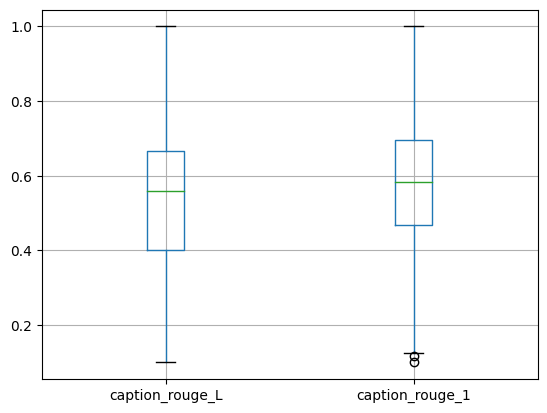

In [9]:
df.boxplot() 


In [15]:
df.boxplot(  rot=75, fontsize=10) 


<Axes: >

In [14]:

# Import libraries
import matplotlib.pyplot as plt
 
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(df["caption_rouge_L",	"caption_rouge_1" ])
 
# show plot
plt.show()

KeyError: ('caption_rouge_L', 'caption_rouge_1')

In [64]:
caption_rouge.boxplot(    ) 

<Axes: >

# To clean

In [ ]:
score_type = 'rougeL'
df[f'caption_rouge_score_l_p' ], df[f'caption_rouge_scorel_r' ], df[f'caption_rouge_scorel_f' ] = df.apply(
    lambda x: calculate_rouge_dataset(x['caption_fr_translated_en'] , x['caption_en'],score_type).precision, axis=1)


In [42]:
df.describe()

,caption_rouge_score_l_p,caption_rouge_scorel_r,caption_rouge_scorel_f,caption_rouge_score_1_p,caption_rouge_score_1_r,caption_rouge_score_1_f
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.579736,0.512468,0.535719,0.623736,0.551623,0.576478
std,0.206628,0.190092,0.186223,0.192615,0.175935,0.169777
min,0.083333,0.100000,0.100000,0.100000,0.100000,0.100000
25%,0.428571,0.356092,0.384615,0.500000,0.421053,0.461538
50%,0.571429,0.533333,0.555556,0.600000,0.545455,0.571429
75%,0.727273,0.600000,0.642857,0.750000,0.642857,0.666667
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [51]:
caption_rouge_L = df.loc[:, df.columns.isin(
    [#"caption_rouge1_p", "caption_rouge1_r", "caption_rouge1_f",
           "caption_rouge_score_l_p", "caption_rouge_scorel_r",	"caption_rouge_scorel_f"]
)]
caption_rouge_L.describe() 

,caption_rouge_score_l_p,caption_rouge_scorel_r,caption_rouge_scorel_f
count,1000.000000,1000.000000,1000.000000
mean,0.579736,0.512468,0.535719
std,0.206628,0.190092,0.186223
min,0.083333,0.100000,0.100000
25%,0.428571,0.356092,0.384615
50%,0.571429,0.533333,0.555556
75%,0.727273,0.600000,0.642857
max,1.000000,1.000000,1.000000


In [54]:
caption_rouge_L.boxplot( rot=75, fontsize=10) 

<Axes: >

In [55]:
caption_rouge_1 = df.loc[:, df.columns.isin(
    ["caption_rouge_score_1_p", "caption_rouge_score_1_r", "caption_rouge_score_1_f",
     #      "caption_rougel_p", "caption_rougel_r",	"caption_rougel_f"
     ]
)]
caption_rouge_1.describe() 

,caption_rouge_score_1_p,caption_rouge_score_1_r,caption_rouge_score_1_f
count,1000.000000,1000.000000,1000.000000
mean,0.623736,0.551623,0.576478
std,0.192615,0.175935,0.169777
min,0.100000,0.100000,0.100000
25%,0.500000,0.421053,0.461538
50%,0.600000,0.545455,0.571429
75%,0.750000,0.642857,0.666667
max,1.000000,1.000000,1.000000


In [56]:
caption_rouge_1.boxplot( rot=75, fontsize=10) 

df.boxplot(column=[#"caption_rouge1_p", "caption_rouge1_r", "caption_rouge1_f",
           "caption_rougel_p", "caption_rougel_r",	"caption_rougel_f"],  rot=75, fontsize=10) 

<Axes: >